In [109]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import collections
import urllib2
import json
import math
from shapely import geometry

# Ignore warnings from various packages.
import warnings
warnings.filterwarnings("ignore")

# Set project explicitly in the environment to suppress some warnings.
os.environ["GOOGLE_CLOUD_PROJECT"] = "measurement-lab"

# Load M-Lab site metadata including site latitude & longitude.
mlab_sites_url = 'https://storage.googleapis.com/operator-mlab-oti/metadata/v0/current/mlab-site-stats.json'

# Load the Natural Earth country shapes file.
worldmap_url = 'https://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_50m_admin_0_countries.geojson'

# Short list of metros in Africa, for convenience.
african_metros = ['tun', 'jnb', 'cpt', 'mpm', 'tnr', 'los', 'nbo', 'acc']

# Number of colors to use when coloring maps.
colors = 10

# Default figure size. W x H.
figsize = (16, 10)


windows = {
    'NA': ((-180, -50), (0, 80)),
    'AF': ((-30, 70), (-40, 40)),
    'OC': ((100, 180), (-50, 0)),
    'AS': ((20, 180), (-20, 50)),
    'EU': ((-20, 20), (30, 60)),
    'SA': ((-100, -30), (-60, 20))}

In [2]:
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='measurement-lab'):
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=600):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

In [43]:
# Load shape data.
globe_raw = gpd.read_file(worldmap_url)

# Select the global information (except Antarctica).
globe = globe_raw[['iso_a2', 'continent', 'geometry']].to_crs('+proj=longlat')
globe = globe[globe.continent != 'Antarctica']
# Add a new column with a default value of zero to show countries without data.
globe['default'] = 0

# Select only Africa.
africa = globe[globe.continent == 'Africa'].copy()
africa['default'] = 0
africa.sample(5)


,iso_a2,continent,geometry,default
20,BJ,Africa,"POLYGON ((3.59541015625001 11.6962890625, 3.55...",0
37,CF,Africa,"POLYGON ((22.86005859375001 10.919677734375, 2...",0
128,LS,Africa,"POLYGON ((28.7369140625 -30.101953125, 28.6468...",0
43,CM,Africa,"POLYGON ((15.480078125 7.523779296874991, 15.3...",0
194,SL,Africa,(POLYGON ((-12.52607421874993 7.43632812500001...,0


In [40]:
# Download the M-Lab site configuration.
response = urllib2.urlopen(mlab_sites_url)
sites = json.loads(response.read())

# Collect all sites in Africa, creating a geometry.Point for each one.
all_map = {}
africa_map = {}
for row in sites:
    metro = row['site'][0:3]
    all_map[metro] = (metro, geometry.Point(row['longitude'], row['latitude']))
    if metro in african_metros:
        africa_map[metro] = all_map[metro]

# Convert the dict into a GeoDataFrame.
all_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(
    all_map, orient='index', columns=['metro', 'location']), geometry='location')
africa_locations = gpd.GeoDataFrame(pd.DataFrame.from_dict(
    africa_map, orient='index', columns=['metro', 'location']), geometry='location')

In [111]:
rates_df = run_query("""
SELECT
  week,
  APPROX_QUANTILES(IF(direction = "s2c", download, NULL), 10)[OFFSET(5)] AS value_download_median_rate,
  APPROX_QUANTILES(IF(direction = "c2s", upload, NULL), 10)[OFFSET(5)] AS value_upload_median_rate,
  FORMAT("%.1f,%.1f", latitude, longitude) as latlong,
  latitude,
  longitude,
  country_code,
  continent_code,
  COUNT(*) AS value_tests
FROM (
  SELECT
    -- Date
    TIMESTAMP_TRUNC(log_time, WEEK) as week,
    -- Direction
    CASE connection_spec.data_direction
      WHEN 0 THEN "c2s"
      WHEN 1 THEN "s2c"
      ELSE "error"
    END AS direction,
    -- Download as bits-per-second
    8 * 1000000 * (web100_log_entry.snap.HCThruOctetsAcked / (
        web100_log_entry.snap.SndLimTimeRwin +
        web100_log_entry.snap.SndLimTimeCwnd +
        web100_log_entry.snap.SndLimTimeSnd)) AS download,
    -- Upload as bits-per-second
    8 * 1000000 * (web100_log_entry.snap.HCThruOctetsReceived /
        web100_log_entry.snap.Duration) AS upload,
    -- Client Lat/Lon.
    ROUND(connection_spec.client_geolocation.latitude, 1) AS latitude,
    ROUND(connection_spec.client_geolocation.longitude, 1) AS longitude,
    connection_spec.client_geolocation.country_code AS country_code,
    connection_spec.client_geolocation.continent_code AS continent_code
  FROM
    `measurement-lab.ndt.base`
  WHERE 
        TIMESTAMP_TRUNC(log_time, DAY) >= TIMESTAMP("2018-10-01") 
    -- AND connection_spec.client_geolocation.continent_code IN ("AF")
    -- Basic test quality filters for safe division.
    AND web100_log_entry.snap.Duration > 0
    AND (web100_log_entry.snap.SndLimTimeRwin +
         web100_log_entry.snap.SndLimTimeCwnd + 
         web100_log_entry.snap.SndLimTimeSnd) > 0
    AND web100_log_entry.snap.CountRTT > 0
    AND web100_log_entry.snap.HCThruOctetsReceived > 0
    AND web100_log_entry.snap.HCThruOctetsAcked > 0
)
GROUP BY
  week, latitude, longitude, country_code, continent_code
HAVING
  value_tests > 10
  AND value_download_median_rate IS NOT NULL
  AND value_upload_median_rate IS NOT NULL
  AND latitude IS NOT NULL
  AND longitude IS NOT NULL
ORDER BY
  value_tests
""")

In [6]:
rates_df.sample(5)

,continent_code,country_code,latitude,latlong,longitude,value_download_median_rate,value_tests,value_upload_median_rate
24633,EU,FR,47.7,"47.7,7.5",7.5,1.966493e+06,425,5.464230e+05
41495,EU,IT,41.6,"41.6,13.4",13.4,3.303190e+06,4204,6.024141e+05
25532,NA,US,33.8,"33.8,-92.4",-92.4,8.265947e+06,469,3.178729e+06
14759,NA,US,39.7,"39.7,-79.4",-79.4,1.804099e+06,134,5.187021e+06
7506,NA,MX,18.7,"18.7,-100.2",-100.2,5.825971e+06,47,2.414121e+06


In [136]:
rates_df['Coordinates'] = list(zip(rates_df.longitude, rates_df.latitude))
rates_df['Coordinates'] = rates_df['Coordinates'].apply(geometry.Point)
rates_df['markersize'] = rates_df['value_tests'].apply(math.log10).apply(lambda x: math.pow(x, 1))
rates_df['download_mbps'] = rates_df['value_download_median_rate'] / 1e6

gdf = gpd.GeoDataFrame(rates_df, geometry='Coordinates')
gdf.sample(5)

,continent_code,country_code,latitude,latlong,longitude,value_download_median_rate,value_tests,value_upload_median_rate,week,Coordinates,markersize,download_mbps
53291,NA,US,44.9,"44.9,-91.7",-91.7,2.801146e+07,24,1.146047e+07,2018-11-04 00:00:00+00:00,POINT (-91.7 44.9),1.380211,28.011458
192446,NA,US,41.4,"41.4,-71.5",-71.5,2.355034e+07,381,9.717582e+06,2018-11-11 00:00:00+00:00,POINT (-71.5 41.4),2.580925,23.550336
182095,EU,DE,52.2,"52.2,10.0",10.0,2.256748e+07,284,5.070058e+06,2018-10-21 00:00:00+00:00,POINT (10 52.2),2.453318,22.567477
136885,NA,CA,45.4,"45.4,-80.0",-80.0,5.955870e+06,103,1.515076e+06,2018-11-11 00:00:00+00:00,POINT (-80 45.4),2.012837,5.955870
74162,NA,CA,45.2,"45.2,-73.5",-73.5,1.847007e+07,34,1.198490e+06,2018-10-07 00:00:00+00:00,POINT (-73.5 45.2),1.531479,18.470069


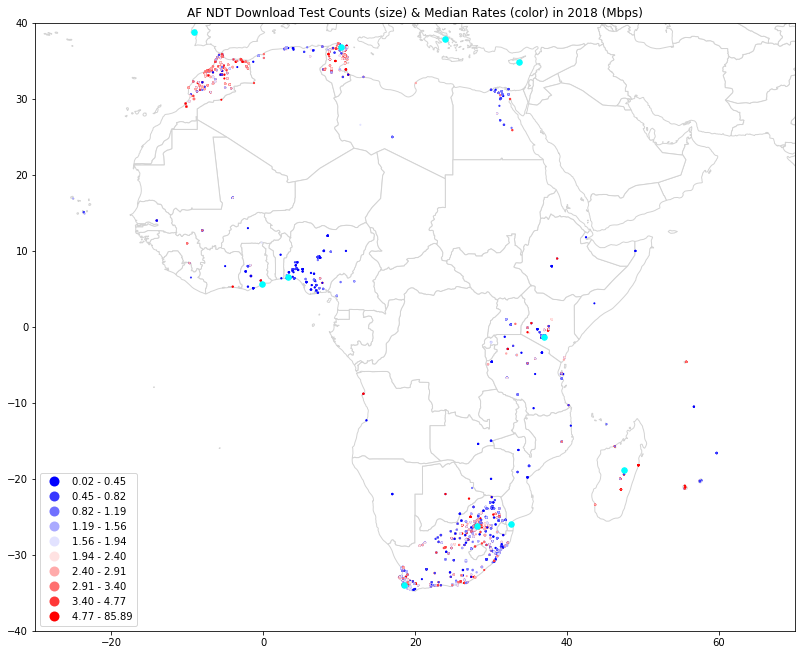

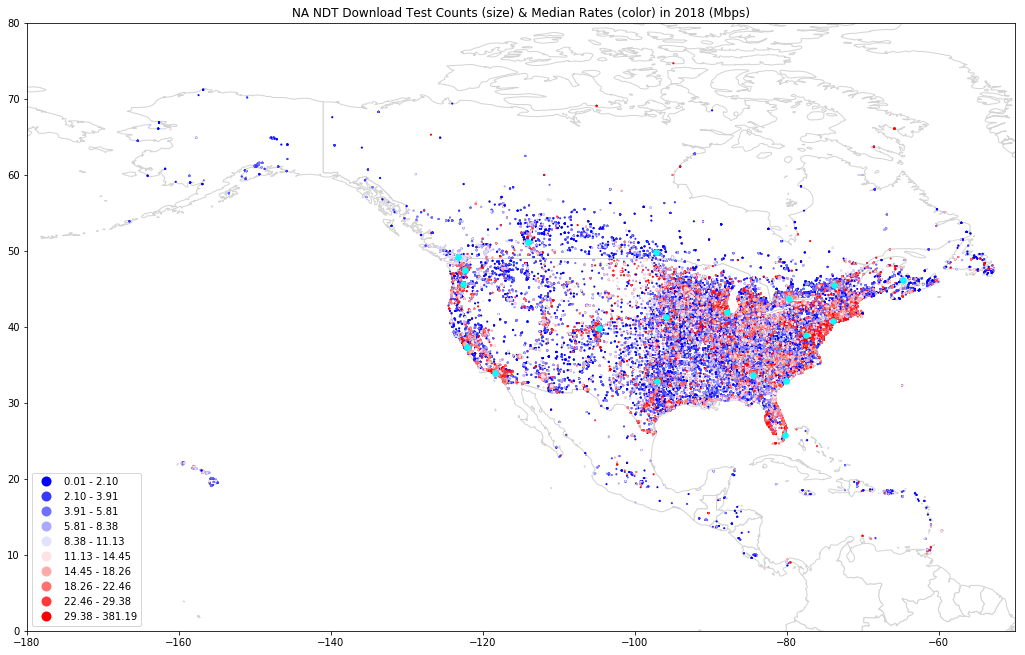

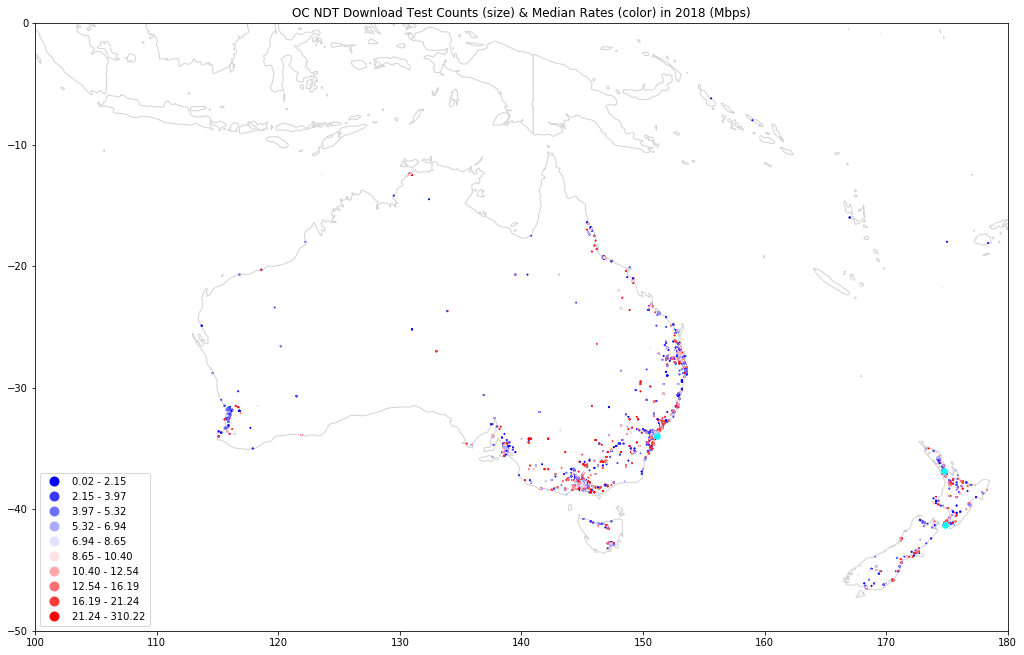

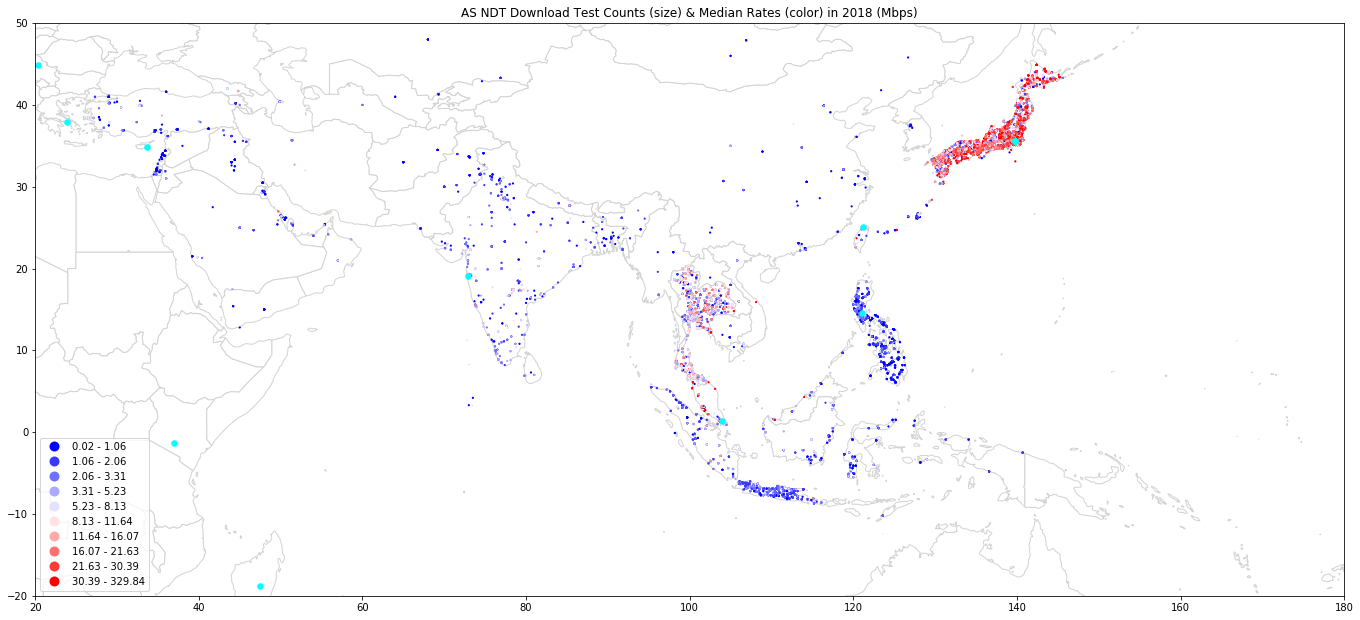

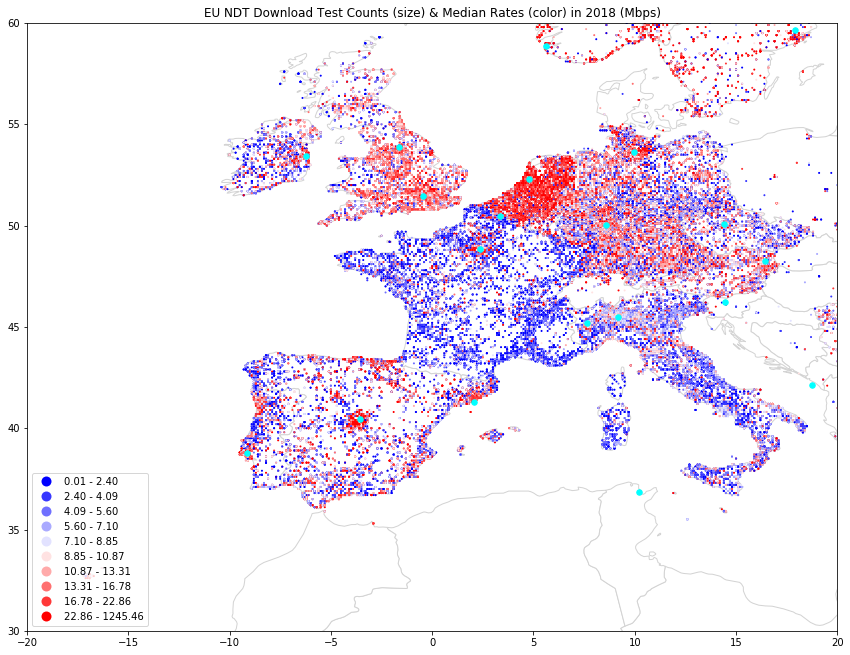

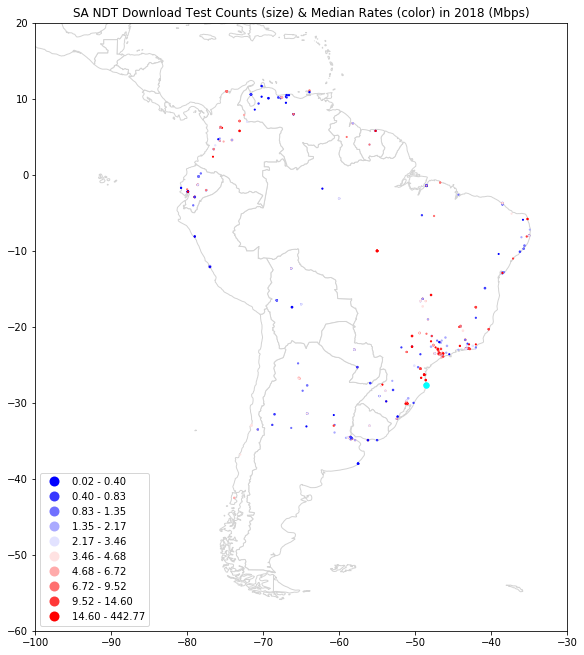

In [141]:
for cont, ((lon_min, lon_max), (lat_min, lat_max)) in windows.iteritems():
    ax0 = globe.plot(column='default', color='white', figsize=(19, 10), edgecolor='lightgrey') # , figsize=figsize)
    ax1 = gdf[gdf.continent_code == cont].plot(
        ax=ax0, column='download_mbps', figsize=(19, 10),
        cmap='bwr', scheme='Quantiles', k=10,
        markersize=gdf[gdf.country_code == cont]['markersize'], legend=True, legend_kwds={"loc": 3},)
    all_locations.plot(ax=ax1, color='Cyan', markersize=30)
    ax1.set_title('%s NDT Download Test Counts (size) & Median Rates (color) in 2018 (Mbps)' % cont)
    ax1.set_xbound(lon_min, lon_max)
    ax1.set_ybound(lat_min, lat_max)
    ax1.get_figure().tight_layout(rect=[0, 0.03, 1, 0.95])
#print dir(ax1)

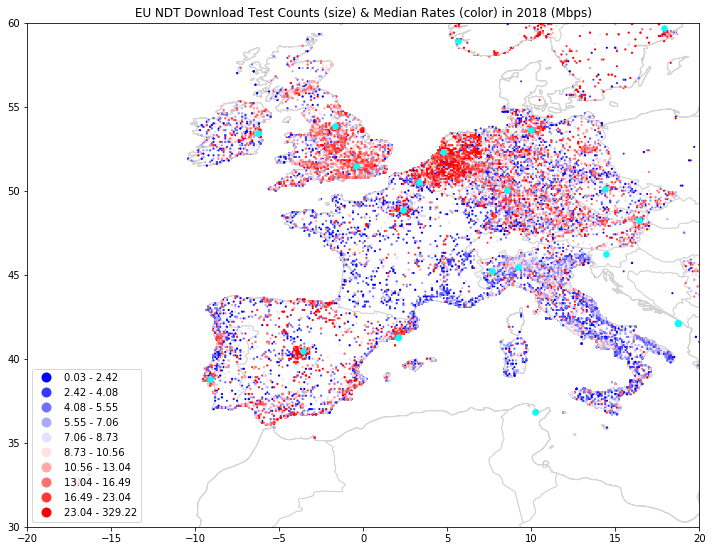

In [140]:

fig, ax = plt.subplots(figsize=(10, 10))
weeks = set(gdf[(gdf.continent_code == 'EU')]['week'])
#ax = fig.add_subplot(111)

# animation function. This is called sequentially
def animate(week):

    for cont, ((lon_min, lon_max), (lat_min, lat_max)) in [('EU', windows['EU'])]:

        ax0 = globe.plot(ax=ax, column='default', color='white',
                         figsize=(10, 10), edgecolor='lightgrey')
        ax1 = gdf[(gdf.continent_code == cont) & (gdf.week == week)].plot(
            ax=ax0, column='download_mbps', figsize=(10, 10),
            cmap='bwr', scheme='Quantiles', k=10,
            markersize=gdf[(gdf.continent_code == cont) & (gdf.week == week)]['markersize'],
            legend=True, legend_kwds={"loc": 3},)
        all_locations.plot(ax=ax1, color='Cyan', markersize=30)
        ax1.set_title('%s NDT Download Test Counts (size) & Median Rates (color) in 2018 (Mbps)' % cont)
        ax1.set_xbound(lon_min, lon_max)
        ax1.set_ybound(lat_min, lat_max)
        ax1.get_figure().tight_layout(rect=[0, 0.03, 1, 0.95])
    return
     
anim = animation.FuncAnimation(fig, animate, frames=weeks, interval=500) # , blit=True)
#rc('animation', html='html5')
#anim
#fig.clear()
HTML(anim.to_html5_video())


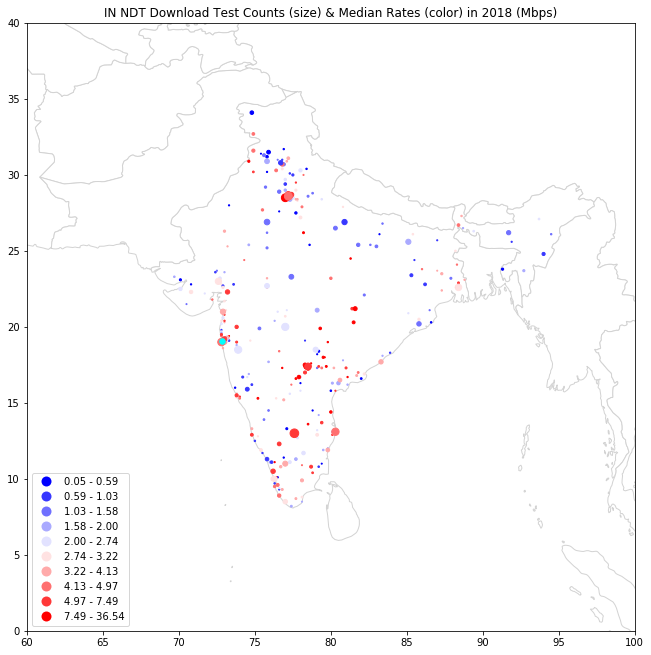

In [108]:
for cont, ((lon_min, lon_max), (lat_min, lat_max)) in [('IN', ((60, 100), (0, 40)))]:
    ax0 = globe.plot(column='default', color='white', figsize=(19, 10), edgecolor='lightgrey') # , figsize=figsize)
    ax1 = gdf[gdf.country_code == cont].plot(ax=ax0, column='download_mbps', figsize=(19, 10), cmap='bwr', scheme='Quantiles',
               k=10, markersize=gdf[gdf.country_code == cont]['markersize'], legend=True, legend_kwds={"loc": 3},)
    all_locations.plot(ax=ax1, color='Cyan', markersize=30)
    ax1.set_title('%s NDT Download Test Counts (size) & Median Rates (color) in 2018 (Mbps)' % cont)
    ax1.set_xbound(lon_min, lon_max)
    ax1.set_ybound(lat_min, lat_max)
    ax1.get_figure().tight_layout(rect=[0, 0.03, 1, 0.95])

In [9]:
print gdf.plot.__doc__


    Plot a GeoDataFrame.

    Generate a plot of a GeoDataFrame with matplotlib.  If a
    column is specified, the plot coloring will be based on values
    in that column.

    Parameters
    ----------
    df : GeoDataFrame
        The GeoDataFrame to be plotted.  Currently Polygon,
        MultiPolygon, LineString, MultiLineString and Point
        geometries can be plotted.
    column : str, np.array, pd.Series (default None)
        The name of the dataframe column, np.array, or pd.Series to be plotted.
        If np.array or pd.Series are used then it must have same length as
        dataframe. Values are used to color the plot. Ignored if `color` is
        also set.
    cmap : str (default None)
        The name of a colormap recognized by matplotlib.
    color : str (default None)
        If specified, all objects will be colored uniformly.
    ax : matplotlib.pyplot.Artist (default None)
        axes on which to draw the plot
    categorical : bool (default False)
        I

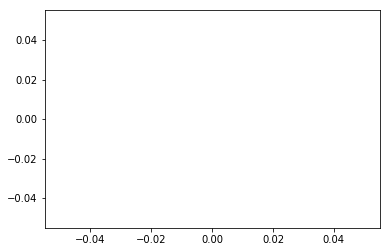

In [128]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

reload(animation)

fig = plt.figure()
ax = fig.add_subplot(111)
#fig, ax = plt.subplots()

#ax.set_xlim(( 0, 2))
#ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)
#HTML(anim.to_html5_video())
#anim
rc('animation', html='html5')
anim